In [2]:
import rmtchem 
import timeit
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import imp
import cantera as ct
imp.reload(rmtchem)
from scipy.sparse import csr_matrix
plt.rcParams.update({'font.size': 16, 'pdf.fonttype':42,'text.usetex': False, 'font.family': 'serif'})

### Example graph 

57


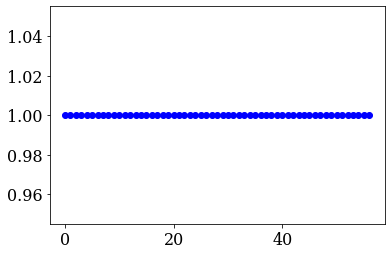

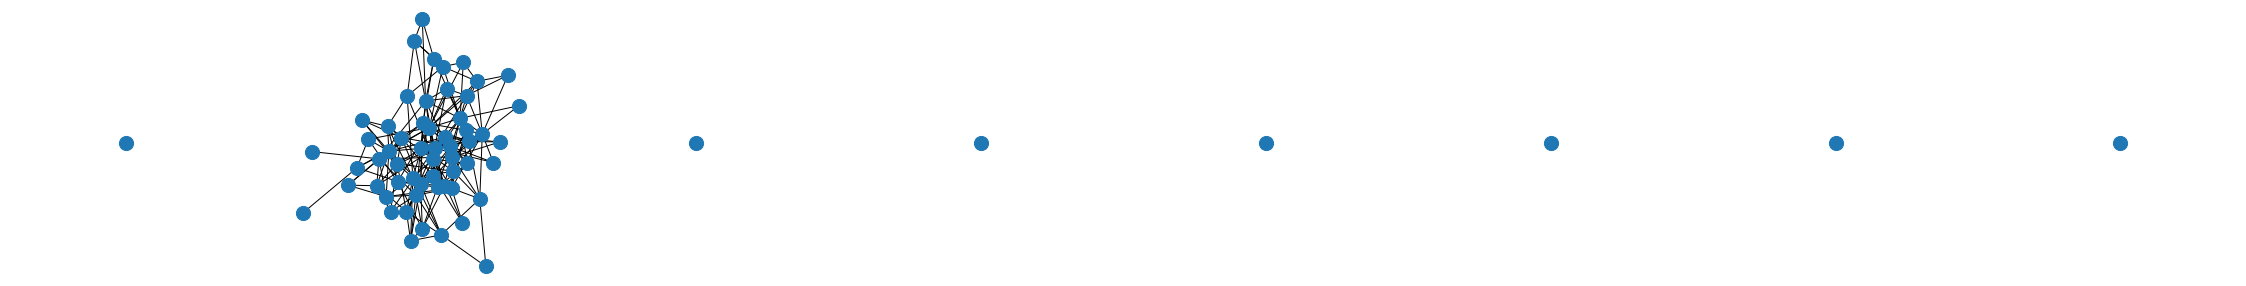

In [2]:
n=64
c=0.5
nr=int(c*n)
seed=1

np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr)
adj=np.zeros((n,n))
for r in range(2*nr):
    reac=np.where(eta[r]>0)[0]
    prod=np.where(nu[r]>0)[0]
    for i in reac:
        for j in prod:
            adj[i,j]=1
        #if species are both reactants, they affect rates of change of each other
        for j in reac:
            adj[i,j]=1
g=nx.convert_matrix.from_numpy_matrix(adj)

lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]

print(n)
X0=np.exp(-G)
XD1=np.zeros(n)
XD2=np.zeros(n)
success,Xs2=rmtchem.steady(X0,eta,nu,k,XD1,XD2)
plt.plot(Xs2/X0,'bo')
plt.show()

g=nx.convert_matrix.from_numpy_matrix(adj)
components=list(sorted(nx.connected_components(g)))
if len(components)>1:
    fig, ax = plt.subplots(1,len(components),figsize=(5*len(components),5))
    for i in range(len(components)):
        comp=list(components)[i]
        idx=np.array(list(comp))
        nx.draw(nx.convert_matrix.from_numpy_matrix(adj[np.ix_(idx,idx)]),node_size=200,ax=ax[i])
        ax[i].axis('off')
else:
    nx.draw(g,node_size=200)

plt.savefig('plots/fig1b.pdf')
plt.show()
# Xs,success=rmtchem.integrate(X0,eta,nu,k,XD1,XD2,100,0.1,prog=True)
# plt.plot(Xs)
# plt.show()

### Chemical network percolation

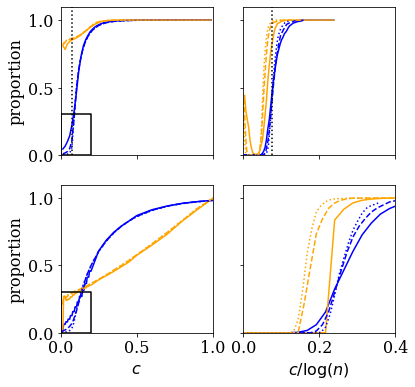

In [202]:
ns=[64,512,4096]
ls=['-','--',':']

plt.subplots(2,2,figsize=(6,6))

plt.subplot(2,2,1)
plt.ylabel("proportion")
plt.ylim(0,1.1)
plt.xlim(0,1)
locs, labels = plt.xticks()
plt.xticks(locs,[])

for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/er/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/(20/3),dat[:,2],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1]/(20/3),dat[:,3],color='orange',linestyle=ls[i])
plt.plot([0,0.2,0.2,0,0],[0.3,0.3,0,0,0.3],color='black')
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')

plt.subplot(2,2,2)
plt.ylim(0,1.1)
plt.xlim(0,0.4)
locs, labels = plt.yticks()
plt.yticks(locs,[])
plt.ylim(0,1.1)

locs, labels = plt.xticks()
plt.xticks(locs,[])
for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/er/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/(20/3)/np.log(n),dat[:,4],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1]/(20/3)/np.log(n),dat[:,5],color='orange',linestyle=ls[i])
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')

plt.subplot(2,2,3)
plt.xlabel('$c$')
plt.ylabel("proportion")
plt.ylim(0,1.1)
plt.xlim(0,1)
for i in range(len(ns)):
    n=ns[i]
    dat=np.loadtxt('data/sing/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1],dat[:,2],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1],dat[:,3],color='orange',linestyle=ls[i])
    
plt.plot([0,0.2,0.2,0,0],[0.3,0.3,0,0,0.3],color='black')

plt.subplot(2,2,4)
plt.xlabel('$c/\log(n)$')
plt.xlim(0,0.4)
plt.ylim(0,1.1)
locs, labels = plt.yticks()
plt.yticks(locs,[])
plt.ylim(0,1.1)

for i in range(len(ns)):
    n=ns[i]
    dat=np.loadtxt('data/sing/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/np.log(n),dat[:,4],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1]/np.log(n),dat[:,5],color='orange',linestyle=ls[i])
plt.savefig('plots/fig2.pdf')
plt.show()

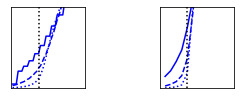

In [5]:
ns=[64,512,4096]
ls=['-','--',':']
fig, axs = plt.subplots(1,2,figsize=(4,1.5))

plt.subplot(1,2,1)
plt.xlim(0,0.2)
plt.ylim(0,0.3)
plt.yticks([],[])
plt.xticks([],[])

for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/sing/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1],dat[:,2],color='blue',linestyle=ls[i])
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')

plt.subplot(1,2,2)
plt.xlim(0,0.2)
plt.ylim(0,0.3)
plt.yticks([],[])
plt.xticks([],[])

for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/er/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/(20/3),dat[:,2],color='blue',linestyle=ls[i])
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')
plt.subplots_adjust(wspace=1.0,hspace=0.0)

plt.savefig('plots/fig2insets.pdf')
plt.show()


### Bifurcation examples

In [ ]:
imp.reload(rmtchem)
n=64
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=0
seed=977
np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
steps=10000
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
start=timeit.default_timer()
Xs,epsilons,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2, d1min,d1max,(d1max-d1min)/steps,output=True,stop=False)

plt.plot(epsilons,np.max(np.real(evals),axis=1))
plt.show()
plt.yscale('log')
plt.plot(epsilons,Xs)
plt.show()

plt.yscale('log')
plt.plot(epsilons[:-1],np.diff(epsilons))
plt.show()

0.119400	
Changed too much! decreasing step 11.930000 	0.010000	0.223705	1.281891	0.011955	0.016579
0.119450	
Changed too much! decreasing step 11.940000 	0.005000	0.158381	0.910125	0.008571	0.011955
0.119475	
Changed too much! decreasing step 11.945000 	0.002500	0.111342	0.645752	0.006135	0.008571
0.119500	
Changed too much! decreasing step 11.947500 	0.002500	0.707300	0.913668	0.000839	0.006135
0.119487	
Changed too much! decreasing step 11.947500 	0.001250	0.077433	0.456834	0.004399	0.006135
0.119494	
Changed too much! decreasing step 11.948750 	0.000625	0.052963	0.321436	0.003177	0.004399
0.119494	
Saddle-node bifurcation! 11.94937499999979
0.113559	
Branch lost! decreasing step 11.358437 -0.002500	
0.113572	
Saddle-node bifurcation! 11.357187499999798
0.113597	
Bifurcation expected, decreasing step! 	11.359687	0.001250	-0.001149


False


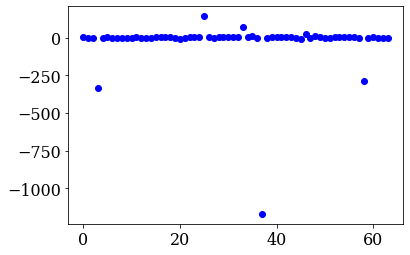

-0.0303497521954052


KeyboardInterrupt: 

In [1412]:
imp.reload(rmtchem)

m=len(Xs)-1
epsilon=epsilons[m]*1.01
np.random.seed(3)
success,solx=rmtchem.steady(Xs[m],eta, nu, k, (1+epsilon)*XD1,XD2)
print(success)
plt.plot(Xs[m]/(solx),'bo')
plt.show()

mat=rmtchem.jac(0,Xs[m],eta, nu, k, (1+epsilon)*XD1,XD2)
ev,evec=np.linalg.eig(mat)
print(np.max(np.real(ev)))

X2,success=rmtchem.integrate(Xs[m]*(1+(0.5-np.random.random(size=n))*1e-2), eta, nu, k, (1+epsilon)*XD1,XD2,1e4,1e0,prog=True)

success,solx=rmtchem.steady(X2[-1],eta, nu, k, (1+epsilon)*XD1,XD2)
print(success)
plt.plot(X2[-1]/(solx),'bo')
plt.show()

mat=rmtchem.jac(0,solx,eta, nu, k, (1+epsilon)*XD1,XD2)
ev,evec=np.linalg.eig(mat)
print(np.max(np.real(ev)))

plt.yscale('log')
plt.plot(X2/Xs[m])
plt.show()

In [1370]:
imp.reload(rmtchem)
X2s,epsilon2s,eval2s,bif=rmtchem.quasistatic(solx, eta, nu, k, XD1, XD2, epsilon,d1min,steps,True, False)
X3s,epsilon3s,eval3s,bif=rmtchem.quasistatic(solx, eta, nu, k, XD1, XD2, epsilon,d1max,steps,True, False)

0.154640		
Changed too much! decreasing step 13.201612 	-0.011848	0.587210	3.854871	0.273187	0.381828
0.155019	
Changed too much! decreasing step 13.189764 	-0.005924	0.691386	2.457182	0.176252	0.273187
test5209	

Branch lost! decreasing step 13.183840 -0.002962	

Failed to converge!  13.18383980054037


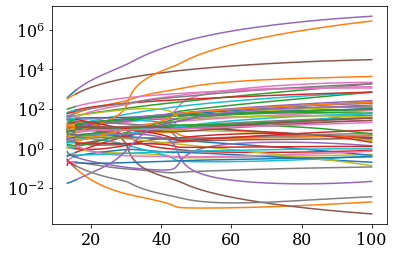

In [1377]:
plt.yscale('log')
plt.plot(epsilon2s,X2s/np.exp(-G))
plt.plot(epsilon3s,X3s/np.exp(-G))
plt.show()

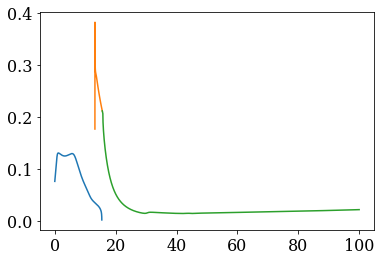

In [1371]:
plt.plot(epsilons,np.min(np.abs(evals),axis=1))
plt.plot(epsilon2s,np.min(np.abs(eval2s),axis=1))
plt.plot(epsilon3s,np.min(np.abs(eval3s),axis=1))

ValueError: could not broadcast input array from shape (19) into shape (3253)

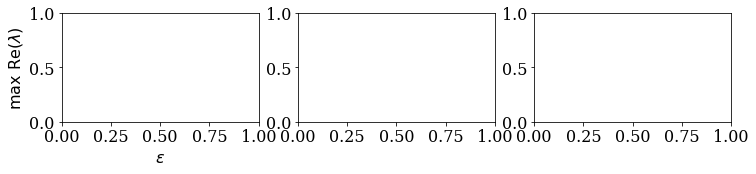

In [565]:
m=len(Xs)-1
m2=len(X2s)-1
plt.subplots(1,3,figsize=(12,2))
plt.subplot(1,3,1)
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\mathrm{max}~\mathrm{Re}(\lambda)$')
evals4=np.zeros(steps)
evals5=np.zeros(steps)
d1s=np.arange(d1min,d1max,(d1max-d1min)/steps)
evals4[:m+1]=np.max(np.real(evals),axis=1)
evals4[m+1:]=np.max(np.real(evals3),axis=1)
evals5[m+1:]=np.max(np.real(evals3),axis=1)
evals5[m-m2:m+1]=np.flip(np.max(np.real(evals2),axis=1),axis=0)
evals5[:m-m2]=np.max(np.real(evals),axis=1)[:m-m2]
plt.plot(d1s,evals4)
plt.plot(d1s,evals5)

plt.subplot(1,3,2)
lim=1.1*np.max(np.abs(evals[-1,np.argsort(np.real(evals[-1]))[-3:]]))
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
plt.ylabel(r'$\mathrm{Im}(\lambda)$')
plt.xlabel(r'$\mathrm{Re}(\lambda)$')
plt.plot(np.real(evals[-2]),np.imag(evals[-2]),'bo')

plt.subplot(1,3,3)
plt.yscale('log')
plt.ylabel(r"$X_i'/X_i^0$")
plt.xlabel('$\epsilon$')
X4s=np.zeros((steps,n))
X5s=np.zeros((steps,n))
d1s=np.arange(d1min,d1max,(d1max-d1min)/steps)
X4s[:m+1]=Xs
X4s[m+1:]=X3s
X5s[m+1:]=X3s
X5s[m-m2:m+1]=np.flip(X2s,axis=0)
X5s[:m-m2]=Xs[:m-m2]
plt.yscale('log')
plt.ylim(0.01,100)
plt.plot(d1s,X5s/X4s)

plt.subplots_adjust(wspace=0.5,hspace=0.0)
plt.savefig('plots/fig3a.pdf')
plt.show()

In [ ]:
#TODO: do this for the saddle-node bifurcations, and pick one that occurs for intermediate m

In [1189]:
imp.reload(rmtchem)
n=64
nr=79
nd=6
na=0
seed=992
np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na)

row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]

d0=1e3
d1min=0
d1max=100
steps=5000
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
Xs,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2,d1min,d1max, steps, output=False,stop=False)
print(len(Xs),bif)
plt.plot(np.max(np.real(evals),axis=1))
plt.show()

plt.plot(Xs)
plt.yscale('log')
plt.show()

ValueError: too many values to unpack (expected 3)

Integration: 100%|##############################################| Time: 0:00:02


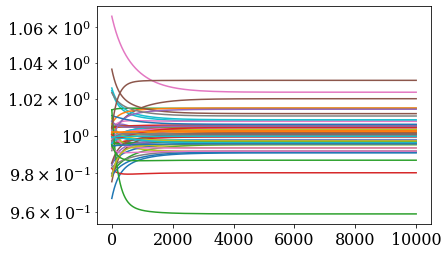

In [153]:
# m=np.where(np.max(np.real(evals),axis=1)>1e-2)[0][0]
m=len(Xs)-1
XD1=XD1s[m+10]
XD2=XD2s[m+10]
X2,success=rmtchem.integrate(Xs[m]*(1+(0.5-np.random.random(size=n))*1e-2), eta, nu, k, XD1,XD2,1e8,1e4,prog=True)
plt.yscale('log')
plt.plot(X2/Xs[m])
plt.show()

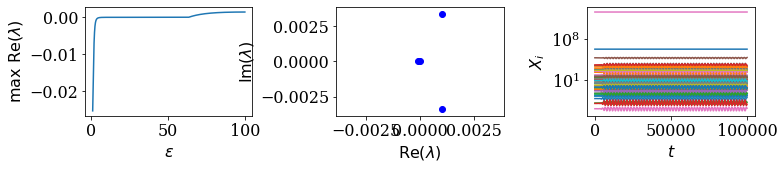

In [99]:
d1s=np.arange(d1min,d1max,(d1max-d1min)/steps)

plt.subplots(1,3,figsize=(12,2))
plt.subplot(1,3,1)
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\mathrm{max}~\mathrm{Re}(\lambda)$')
plt.plot(d1s,np.max(np.real(evals),axis=1))

plt.subplot(1,3,2)
lim=1.1*np.max(np.abs(evals[m,np.argsort(np.real(evals[m]))[-3:]]))
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
# plt.ylim(-0.1,0.1)
plt.ylabel(r'$\mathrm{Im}(\lambda)$')
plt.xlabel(r'$\mathrm{Re}(\lambda)$')
plt.plot(np.real(evals[m]),np.imag(evals[m]),'bo')

plt.subplot(1,3,3)
plt.yscale('log')
plt.ylabel('$X_i$')
plt.xlabel('$t$')
plt.plot(np.arange(0,1e5,1e1),X2)
plt.subplots_adjust(wspace=0.5,hspace=0.0)
plt.savefig('plots/fig3b.pdf')
plt.show()

### Bifurcations vs driving and connectivity

(81, 5)


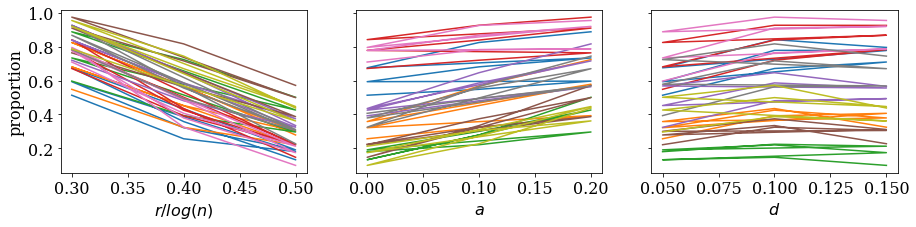

In [7]:
ns=[64,128,256]
cs=[0.3,0.4,0.5]
ds=[0.05,0.1,0.15]
ass=[0,0.1,0.2]
tab=[]
for n in ns:
    for c in cs:
        for d in ds:
            for a in ass:
                vals=np.loadtxt('data/hystereses2/'+str(n)+'_'+str(c)+'_'+str(d)+'_'+str(a)+'.txt')
                tot=np.count_nonzero(vals[:,4]==0)+np.count_nonzero(vals[:,4]==1)+np.count_nonzero(vals[:,4]==2)
                tab.append([c, d, a, np.count_nonzero(vals[:,4]==1)/tot,  np.count_nonzero(vals[:,4]==2)/tot])
                
tab=np.array(tab)
print(tab.shape)
cs=np.unique(tab[:,0])
ds=np.unique(tab[:,1])
ass=np.unique(tab[:,2])

fig,ax=plt.subplots(1,3,figsize=(15,3))
plt.subplot(1,3,1)
plt.xlabel('$r/log(n)$')
plt.ylabel('proportion')
for d in ds:
    for a in ass:
        ind=np.where(np.all(tab[:,[1,2]]==[d,a],axis=1))[0]
        plt.plot(tab[ind,0],tab[ind,4]+tab[ind,3])

plt.subplot(1,3,2)
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
plt.xlabel('$a$')
for d in ds:
    for c in cs:
        ind=np.where(np.all(tab[:,[1,0]]==[d,c],axis=1))[0]
        plt.plot(tab[ind,2],tab[ind,4]+tab[ind,3])

plt.subplot(1,3,3)
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
plt.xlabel('$d$')
for a in ass:
    for c in cs:
        ind=np.where(np.all(tab[:,[2,0]]==[a,c],axis=1))[0]
        plt.plot(tab[ind,1],tab[ind,4]+tab[ind,3])
plt.savefig('plots/fig4.pdf',transparent=True)
plt.show()

(9, 6)


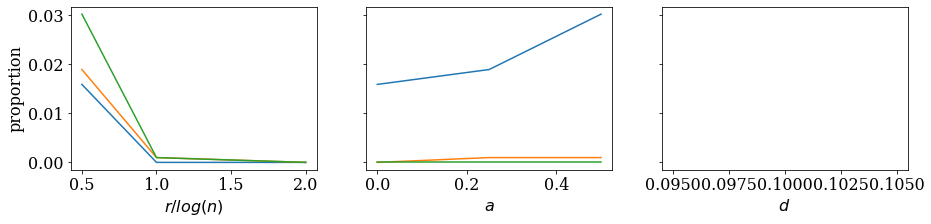

In [1439]:
tab=np.array(tab)
print(tab.shape)
cs=np.unique(tab[:,0])
ds=np.unique(tab[:,1])
ass=np.unique(tab[:,2])

fig,ax=plt.subplots(1,3,figsize=(15,3))
plt.subplot(1,3,1)
plt.xlabel('$r/log(n)$')
plt.ylabel('proportion')
for d in ds:
    for a in ass:
        ind=np.where(np.all(tab[:,[1,2]]==[d,a],axis=1))[0]
        plt.plot(tab[ind,0],tab[ind,5])

plt.subplot(1,3,2)
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
plt.xlabel('$a$')
for d in ds:
    for c in cs:
        ind=np.where(np.all(tab[:,[1,0]]==[d,c],axis=1))[0]
        plt.plot(tab[ind,2],tab[ind,5])

plt.subplot(1,3,3)
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
plt.xlabel('$d$')
for a in ass:
    for c in cs:
        ind=np.where(np.all(tab[:,[2,0]]==[a,c],axis=1))[0]
        plt.plot(tab[ind,1],tab[ind,5])
plt.show()

In [1390]:
tot

1024

(9, 6)


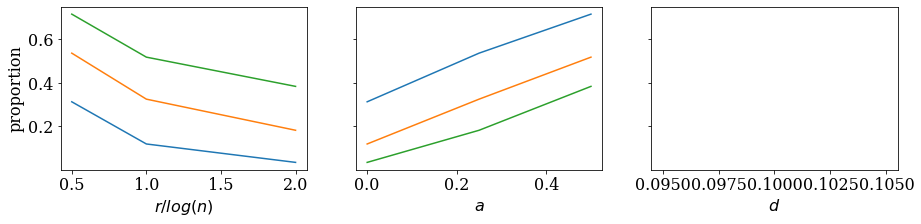

In [1438]:
ns=[64]
cs=[0.5,1.0,2.0]
ds=[0.1]
ass=[0,0.25,0.5]
tab=[]
for n in ns:
    for c in cs:
        for d in ds:
            for a in ass:
                vals=np.loadtxt('data/hystereses/'+str(n)+'_'+str(c)+'_'+str(d)+'_'+str(a)+'.txt')
                tot=np.count_nonzero(vals[:,4]==0)+np.count_nonzero(vals[:,4]==1)+np.count_nonzero(vals[:,4]==2)
                tab.append([c, d, a, np.count_nonzero(vals[:,4]==1)/tot,  np.count_nonzero(vals[:,4]==2)/tot,np.count_nonzero(vals[:,4]<0)/tot])
                
tab=np.array(tab)
print(tab.shape)
cs=np.unique(tab[:,0])
ds=np.unique(tab[:,1])
ass=np.unique(tab[:,2])

fig,ax=plt.subplots(1,3,figsize=(15,3))
plt.subplot(1,3,1)
plt.xlabel('$r/log(n)$')
plt.ylabel('proportion')
for d in ds:
    for a in ass:
        ind=np.where(np.all(tab[:,[1,2]]==[d,a],axis=1))[0]
        plt.plot(tab[ind,0],tab[ind,4]+tab[ind,3])

plt.subplot(1,3,2)
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
plt.xlabel('$a$')
for d in ds:
    for c in cs:
        ind=np.where(np.all(tab[:,[1,0]]==[d,c],axis=1))[0]
        plt.plot(tab[ind,2],tab[ind,4]+tab[ind,3])

plt.subplot(1,3,3)
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
plt.xlabel('$d$')
for a in ass:
    for c in cs:
        ind=np.where(np.all(tab[:,[2,0]]==[a,c],axis=1))[0]
        plt.plot(tab[ind,1],tab[ind,4]+tab[ind,3])
plt.savefig('plots/fig4.pdf',transparent=True)
plt.show()

In [97]:
from scipy.stats import ttest_ind,pearsonr

for n in ns:
    for d in ds:
        for c in cs:
            for a in as:
                vals=np.loadtxt('data/hystereses2/'+str(n)+'_'+str(c)+'_'+str(d)+'_'+str(a)+'.txt')
                x=vals[np.where(vals[:,4]==2.)[0],5]
                y=(vals[np.where(vals[:,4]==2.)[0],8]-vals[np.where(vals[:,4]==2.)[0],9])/c
                print(pearsonr(x,y))

(0.007023553559090158, 0.9398295749215291)
(0.05031621681687626, 0.6596683575935252)
(0.4774085427787028, 0.0013885822371962962)
(-0.01021271270369667, 0.9033048204107208)
(-0.0020229801519840163, 0.9846455974059817)
(-0.07887154440665113, 0.538920812984755)
(0.13433772652730494, 0.18494384253712537)
(-0.056084641418866814, 0.6785993008655892)
(-0.12374386963283965, 0.4020580215137715)


### Empirical reaction network stoichiometry

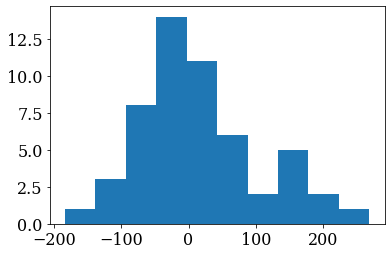

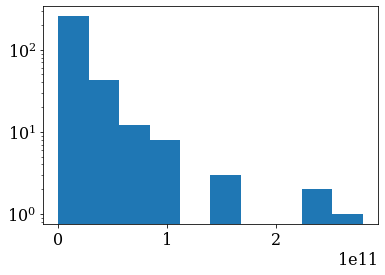

In [7]:
gas=ct.Solution('gri30.cti')
plt.hist(gas.standard_gibbs_RT)
plt.show()
plt.yscale('log')
plt.hist(gas.forward_rate_constants)
plt.show()

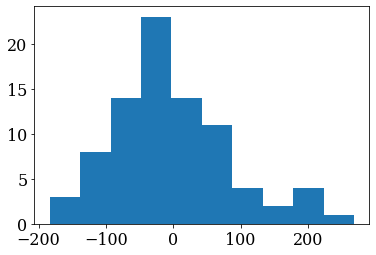

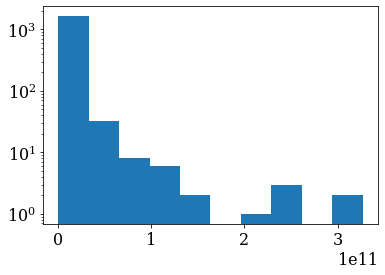

In [8]:
gas=ct.Solution('pyrolysis.cti')
plt.hist(gas.standard_gibbs_RT)
plt.show()
indices=np.where(gas.forward_rate_constants<1e15)[0]
plt.yscale('log')
plt.hist(gas.forward_rate_constants[indices])
plt.show()

# Generate ODE file for AUTO

In [108]:
imp.reload(rmtchem)

<module 'rmtchem' from '/Users/zack/Documents/rmtchem/rmtchem.py'>

In [1494]:
0.000072/0.000080

0.8999999999999999

0.687500	
Hopf bifurcation! 68.74999999999827
0.963200	
Changed too much! decreasing step 96.310000 	0.010000	0.542992	4.375483	1.527481	2.138092
0.963250	
Changed too much! decreasing step 96.320000 	0.005000	0.278685	2.808784	0.991417	1.527481
0.963275	
Bifurcation expected, decreasing step! 	96.327500	0.002500	0.001067
0.963275	
Second branch not found!	1	1	0.000000	0.000000

Bifurcation expected, decreasing step! 	96.327500	0.001250	0.000661
0.963338	
Saddle-node bifurcation! 96.33375000001234
0.842406	
Changed too much! decreasing step 84.245625 	-0.005000	0.898707	4.576128	0.177612	0.256853
0.842406	
Saddle-node bifurcation! 84.24062500002334
15239 11	


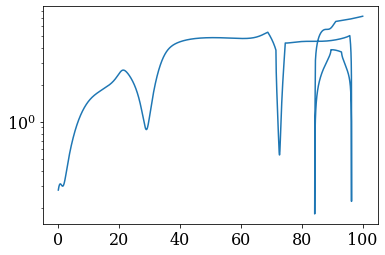

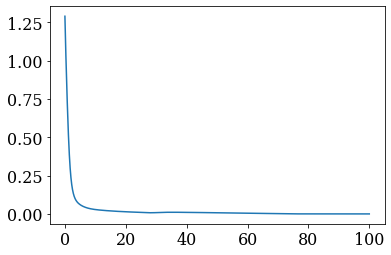

In [1514]:
imp.reload(rmtchem)
n=64
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=0
seed=978
np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
steps=10000
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)

r=np.linalg.matrix_rank(adj.toarray()[np.ix_(lcc,lcc)])
if(r==n):

    Xs,epsilons,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2, d1min,d1max,steps,True, False)
    print(len(Xs),bif)

    file=open('rmtchem.ode','w')
    for i in range(n):
        if i in inds:
            print('X[%i]\'=ep*D[%i]-E[%i]*X[%i]'%(i,i,i,i),end='',file=file)
        else:
            print('X[%i]\'=0'%(i),end='',file=file)
        for j in range(2*nr):
            if((eta[j,i]-nu[j,i])!=0):
                print('+(%i)*%f'%(eta[j,i]-nu[j,i],k[j]),end='',file=file)
                inds2=np.where(nu[j]>0)[0]
                for l in inds2:
                    print('*X[%i]^(%i)'%(l,nu[j,l]),end='',file=file)
        print('\n',end='',file=file)

    for i in range(n):
        print('init X[%i]=%f'%(i,np.exp(-G)[i]),file=file)

    print('par ep=1',file=file)
    for i in range(n):
        if i in inds:
            print('par D[%i]=%f'%(i,XD1[i]),file=file)    
            print('par E[%i]=%f'%(i,XD2[i]),file=file)

    print('@ XP=T,YP=X0,XLO=0,XHI=1000,YLO=0,YHI=10',file=file)
    print('@ meth=cvode,dt=0.01,total=1000,nout=1000',file=file)
    print('@ NTST=50, NMAX=1000000, NPR=0, DSMIN=1e-6, DSMAX=1e-2, DS=1e-3, PARMIN=1.0, PARMAX=100',file=file)
    print('@ EPSU=1e-4, EPSL=1e-4, EPSS=1e-4',file=file)
    ind=np.setdiff1d(np.arange(n),inds)[0]
    print('@ NORMMAX=1e10, AUTOXMIN=0.0, AUTOXMAX=%f, AUTOYMIN=0, AUTOYMAX=%f, AUTOVAR=X%i'%(1.5*epsilons[-1],1.5*np.max(Xs[:,ind]),ind),file=file)
    print('@ runnow=1, bound=100000',file=file)
    print('done',file=file)

    file.close()
    
    plt.yscale('log')
    plt.plot(epsilons,np.min(np.abs(evals),axis=1))
    plt.show()
    plt.plot(epsilons,Xs[:,ind])
    plt.show()

Integration: 100%|##############################################| Time: 0:00:00


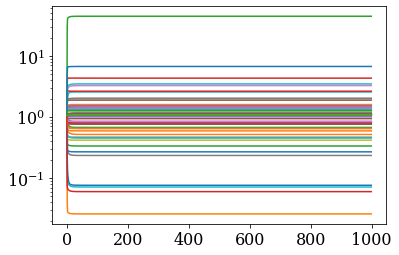

In [1319]:
if bif==1:
    m=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
else:
    m=len(Xs)-1
epsilon=epsilons[m]*1.1
X2,success=rmtchem.integrate(Xs[m]*(1+(0.5-np.random.random(size=n))*0e-2), eta, nu, k, (1+epsilon)*XD1,XD2,1e3,1e0,prog=True)
plt.yscale('log')
plt.plot(X2/Xs[m])
plt.show()

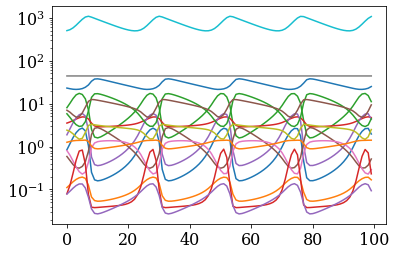

In [1293]:
plt.yscale('log')
plt.plot(X2[-100:])
plt.show()

(array([32.,  4.,  3.,  1.,  1.,  1.,  0.,  1.,  0.,  1.]),
 array([2.24994350e-03, 8.46507731e-01, 1.69076552e+00, 2.53502331e+00,
        3.37928109e+00, 4.22353888e+00, 5.06779667e+00, 5.91205446e+00,
        6.75631224e+00, 7.60057003e+00, 8.44482782e+00]),
 <a list of 10 Patch objects>)

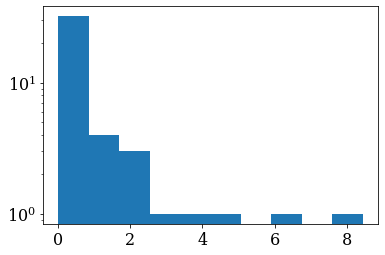

In [1255]:
plt.yscale('log')
plt.hist(k)